In [54]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [55]:
import fabio,pyFAI


In [56]:
ls Aarhus/


dia_cool_001-[phosphor]_fiji.tif  lab6_rt_001.tif
image2.png                        lab6_rt_001.xy
image.png                         large2.svg
lab6_rt_001.azim                  large3.svg
lab6_rt_001.dat                   large.png
lab6_rt_001-mask.edf              large.svg
lab6_rt_001.npt                   mask.edf
lab6_rt_001.npt_old               powder1.png
lab6_rt_001-[phosphor]_fiji.tif   powder2.png
lab6_rt_001.poni                  ReadMe.txt
lab6_rt_001.poni_old              si_cool_003-[phosphor]_fiji.tif


/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


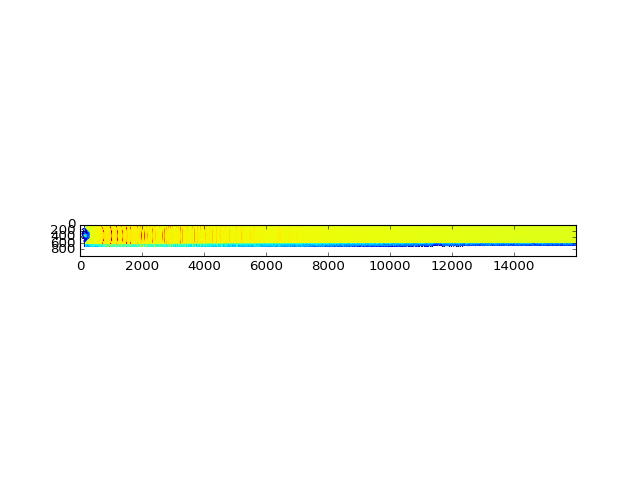

Detector Aarhus	 Spline= None	 PixelSize= 2.500e-05, 2.500e-05 m
Wavelength= 2.070000e-11m
SampleDetDist= 3.011596e-01m	PONI= 6.591954e-03, -1.108204e-03m	rot1=-0.018199  rot2= 0.010729  rot3= 0.000025 rad
DirectBeamDist= 301.227mm	Center: x=174.927, y=392.951 pix	Tilt=1.210 deg  tiltPlanRotation= 30.524 deg


In [64]:
img = fabio.open("Aarhus/lab6_rt_001.tif").data
msk1 = fabio.open("Aarhus/lab6_rt_001-mask.edf").data
ai = pyFAI.load("Aarhus/lab6_rt_001.poni")
imshow(numpy.log(img))
print(ai)

<IPython.core.display.Javascript object>


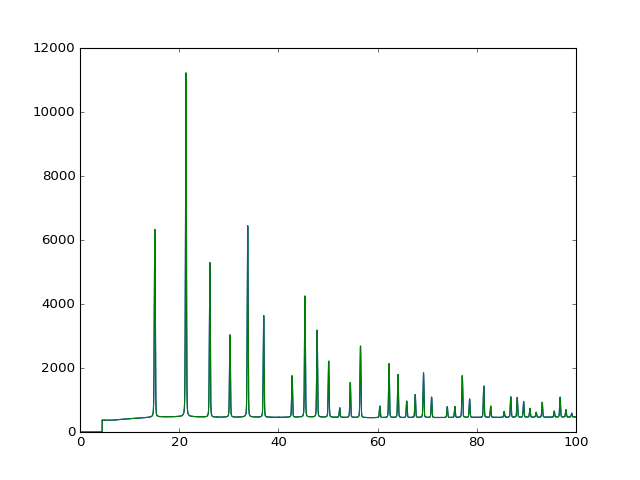

In [65]:
q,I_nc = ai.integrate1d(img,10000, mask=msk1,method="splitpixel", correctSolidAngle=False, radial_range=(0, 100),polarization_factor=0.9)
plot(q,I_nc)
q,I_c = ai.integrate1d(img,10000, mask=msk1,method="splitpixel", correctSolidAngle=True, radial_range=(0, 100),polarization_factor=0.9)
plot(q,I_c)
#close('all')

In [11]:
#dataset from LUND ...

In [59]:
ls Lund/*.edf

Lund/mask.edf          Lund/thetascan2_2.edf  Lund/thetascan2_4.edf
Lund/thetascan2_1.edf  Lund/thetascan2_3.edf  Lund/thetascan2_5.edf


In [66]:
import glob
msk = fabio.open("Lund/mask.edf").data
images = glob.glob("Lund/thetascan*.img")
images.sort()
print(images)
imgs = []
mon = []
for i in images:
    im = fabio.open(i)
    im.data[im.data<0] = 0
    imgs.append(im.data)
    mon.append(float(im.header["Exposure time in sec"]))
ais = [pyFAI.load(i[:-3]+"poni") for i in images]
for ai in ais: 
    ai.detector.mask=msk


['Lund/thetascan_1_1.img', 'Lund/thetascan_2_1.img', 'Lund/thetascan_3_1.img', 'Lund/thetascan_4_1.img', 'Lund/thetascan_5_1.img']


area_pixel=12.413954202591414 area_sum=12.415176249867736, Error= -9.844141974252653e-05
area_pixel=12.388782395580456 area_sum=12.390622514446058, Error= -0.0001485310506590111
area_pixel=20.160486407579487 area_sum=20.168776654523, Error= -0.000411212645166961
area_pixel=0.627155295959902 area_sum=3.0714733948826733, Error= -3.8974686408118155


<IPython.core.display.Javascript object>


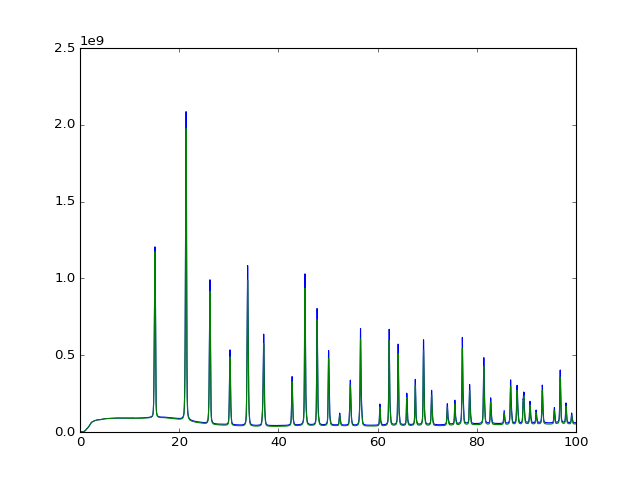

area_pixel=12.413954202591414 area_sum=12.415176249867736, Error= -9.844141974252653e-05
area_pixel=12.388782395580456 area_sum=12.390622514446058, Error= -0.0001485310506590111
area_pixel=20.160486407579487 area_sum=20.168776654523, Error= -0.000411212645166961
area_pixel=0.627155295959902 area_sum=3.0714733948826733, Error= -3.8974686408118155


In [71]:
from pyFAI.multi_geometry import MultiGeometry
mg = MultiGeometry(ais, radial_range=(0, 100), wavelength=1e-10, unit="q_nm^-1")
plot(*mg.integrate1d(imgs, 10000,monitors=mon, polarization_factor=0.9))
plot(*mg.integrate1d(imgs, 10000,monitors=mon, polarization_factor=None))

<IPython.core.display.Javascript object>


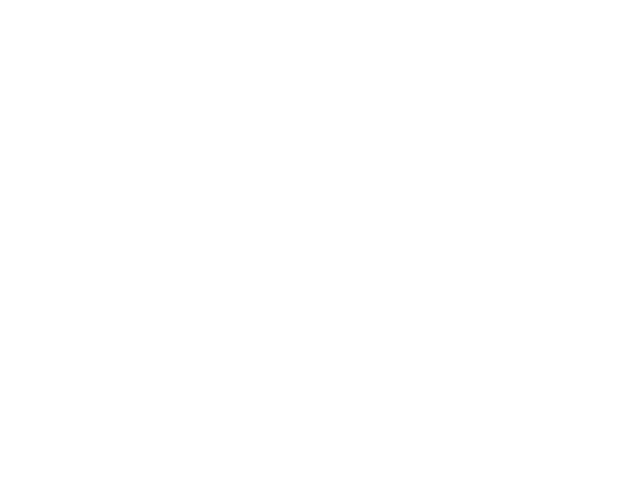

In [72]:
clf()

In [35]:
mon

[10.0, 16.0, 22.0, 28.0, 34.0]